파이프라인 인터페이스 

- pipeline은 전처리나 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있다. 
  
  ( ex) 특성 추출, 특성 선택, 스케일 변경, 분류의 총 네 단계를 포함하는 파이프라인을 만들 수 있다. )
  
- pipeline에 들어갈 추정기는 마지막 단계를 제외하고는 모두 transform 메서드를 가지고 있어야 한다. 

- 내부적으로는 Pipeline.fit 메서드가 실행되는 동안, 파이프라인은 각 단계에서 이전 단계의 transform의 출력을 입력으로 

  받아 fit과 transform 메서드를 차례로 호출한다. 그리고 마지막 단계는 fit 메서드만 호출한다.
  
- 세부사항을 구현하면 pipeline.steps는 튜플의 리스트라서 pipeline.steps[0][1]은 첫번째 추정기이고

  pipeline.steps[1][1]은 두번째 추정기가 되는 식입니다. 

In [1]:
def fit( self, X, y ):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        #마지막 단계 빼고 fit과 transform 반복
        X_transformed = estimator.fit_transform(X_transformed, y)
        
    self.steps[-1][1].fit(X_transformed, y)
    return self

- pipeline을 사용해서 예측할 때는, 비슷한 방식으로 마지막단계 이전 까지 
  
  transform 메서드를 호출한 다음, 마지막 단계에서 predict를 호출한다.

In [2]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        #마지막 단계를 빼고 transform을 반복
        X_transformed = step[1].transform(X_transformed)
    #마지막 단계 predict를 호출
    return self.steps[-1][1].predict(X_transformed)

- 파이프 라인은 실제로 더 다양하게 구성할 수 있다. 
- 파이프라인의 마지막 단계가 predict 함수를 가져아 할 필요는 없으므로 스케일 변환이나 PCA만 포함하는 파이프라인을 만들 수 있다. 
- 예를 들어 스케일 변환, PCA변환만 포함된 파이프라인에 transform 메서드를 호출하면 
  
  이전단계 출력에 PCA.transform을 적용한 결과를 반환한다. 
  
- 파이프라인의 마지막 단계에서는 최소한 fit 메서드는 있어야 한다. 

1) make_pipeline을 사용한 파이프라인 생성

- make_pipeline 함수는 각 단계 이름에 해당 파이썬 클래스의 이름을 부여한 파이프 라인을 만들어 준다.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

#표준
pipe_long = Pipeline([('scaler', MinMaxScaler()),('svm',SVC(C=100))])

#간소화
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

- 위의 두 파이프라인은 똑같은 작업을 수행하지만, short의 경우 단계의 이름을 자동으로 만든다. 

  (steps 속성에 각 단계의 이름이 있다. )

In [5]:
print(' 파이프라인 단계 : \n', pipe_short.steps)

 파이프라인 단계 : 
 [('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False))]


- 단계의 이름은 minmaxscaler와 svc다. ( 클래스의 소문자 버전 , 같은 클래스를 여러번 사용하면 이름뒤에 숫자가 추가로 붙는다.)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())
print('파이프 라인 단계 : \n', pipe.steps)

파이프 라인 단계 : 
 [('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


2) 단계 속성에 접근하기 

- 파이프라인의 단계 중 하나의 속성을 확인하고 싶을때( 선형 모델의 계수, PCA 추출 주성분 등 )named_steps이용하면 된다.

In [9]:
#캔서 데이터 이용
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

pipe.fit(cancer.data)

#'pca'단계에서 두 개 주성분 추출

components = pipe.named_steps['pca'].components_
print('components.shape :', components.shape)

components.shape : (2, 30)


3) 그리드 서치 안의 파이프라인 속성에 접근하기 

- 파이프라인의 주 목적은 그리드 서치를 효율적으로 이용하기 위해서이다. 


In [10]:
#스케일 조정위한 StandaradScaler, LogisticRegression으로 pipeline을 만들어 cancer데이터에 그리드 서치 적용
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(StandardScaler(), LogisticRegression())

#매개변수 그리드 생성
param_grid = {'logisticregression__C':[0.01,0.1,1,10,100]}

#cancer 데이터를 나누고 그리드 서치 적용

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state =4)

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\cndak\appdata\local\programs\python\python37\lib\si

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                     

In [12]:
#최적 매개변수 확인
print('최상의 모델 :\n', grid.best_estimator_)

최상의 모델 :
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


- 위와 같은 경우에 best_estimator_는 StandardScaler, LogisticRegression 두 단계를 거친 파이프라인이다. 
- LogisticRegression 단계에 접근하려면 named_steps 속성 이용

In [13]:
print('로지스틱 회귀 단계 :\n', grid.best_estimator_.named_steps['logisticregression'])

로지스틱 회귀 단계 :
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [15]:
#각 입력 특성에 연결된 계수 출력
print('로지스틱 회귀 계수 :\n', grid.best_estimator_.named_steps['logisticregression'].coef_)

로지스틱 회귀 계수 :
 [[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


전처리와 모델의 매개변수를 위한 그리드 서치 

- 파이프라인을 사용하면 머신러닝 워크플로에 필요한 모든 처리 단계를 하나의 사이킷런 추정기로 캡슐화 할 수 있다. 
- 또 다른 장점으로, 회귀와 분류 같은 지도 학습의 출력을 이용하여 전처리 매개변수를 조정 할 수 있다.

In [23]:
#보스턴 데이터셋에서 다항식 특성을 선택해 릿지 회귀 적용
# 데이터 스케일 조정, 다항식 특성 선택, 릿지 회귀 셰단계의 파이프 라인

from sklearn.datasets import load_boston

boston = load_boston()

X_train, X_test, y_train, y_test, = train_test_split(boston.data, boston.target, random_state = 0)

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import Ridge

pipe = make_pipeline( StandardScaler(), PolynomialFeatures(), Ridge() )

- 다항식 차수가 얼마나 되어야 할지, 또는 다항식이나 교차항이 필요한건지 파악하려면

  분류의 결과에 기초해서 degree 매개변수를 선택해야 한다. 
  
- 파이프라인을 이용하면 Ridge의 alpha 매개변수와 함께 degree 매개변수 함께 탐색 가능

In [24]:
param_grid = {'polynomialfeatures__degree':[1,2,3],
             'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}


In [25]:
grid=GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
         

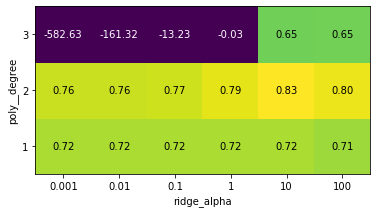

In [27]:
#교차 검증의 결과를 히트맵을 이용해서 표시 

import mglearn

mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
                     xlabel='ridge_alpha', ylabel = 'poly__degree', 
                     xticklabels = param_grid['ridge__alpha'],
                     yticklabels = param_grid['polynomialfeatures__degree'],vmin = 0)

- 교차 검증 결과를 보면 2차항이 효과가 좋고, 3차항은 결과가 나쁘다. 

In [29]:
#최적 매개변수 확인
print('최적 매개변수 :', grid.best_params_)

최적 매개변수 : {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [30]:
#테스트 점수
print('테스트 셋 점수 :', grid.score(X_test, y_test))

테스트 셋 점수 : 0.7683045464100141


In [32]:
#다항식 특성이 없는 그리드 서치와의 비교

param_grid = {'ridge__alpha':[0.001,0.01,0.1,1,10,100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)

print('다항식 특성 X 점수 :', grid.score(X_test, y_test))

다항식 특성 X 점수 : 0.6272671927504456


c:\users\cndak\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


- 다항식 특성이 없는경우 성능이 낮아졌다.
- 모델의 매개변수와 함께 전처리 과정의 매개변수를 찾는 것은 매우 강력한 전략이다. 
- 그리드서치는 지정한 매개변수의 모든 가능한 조합을 시도한다. 그러므로 매개변수 그리드에 많은 변수를 추가하면 

  만들어야 할 모델이 급격히 증가하게 된다. ( 메모리, 시간 증가 )
  
  

모델 선택을 위한 그리드 서치 

- 그리드 섳리와 파이프라인을 연결하는 것에서 더 나아가 파이프라인 구성하는 단계도 탐색 대상으로 삼을 수 있다. 

- 모든 알고리즘을 시도해보는 것이 필수 전략은 아니다. ( 탐색범위가 넓어지기 때문 )


In [47]:
#랜덤포레스트와 SVC 비교 

#SVC 파이프라인 객체 

from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline( [('preprocessing', StandardScaler() ), ('classifier', SVC())] )


param = [
        {'classifier' : [SVC()],
         'classifier__C' : [0.001, 0.01, 0.1, 1, 10],
         'classifier__gamma'  : [0.001, 0.01, 1, 10, 100],
         'preprocessing' : [StandardScaler()]},
        {'classifier' : [RandomForestClassifier(n_estimators=100)],
         'classifier__max_features' : [1, 2, 3],
         'preprocessing' : [None] }
        ]

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target)

grid = GridSearchCV(pipe, param, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

print('최적 매개변수 :\n', grid.best_params_)
print('최상 교차 검증 점수 : \n', grid.best_score_)
print('테스트 셋 점수 :', grid.score(X_test, y_test))


최적 매개변수 :
 {'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}
최상 교차 검증 점수 : 
 0.9765258215962441
테스트 셋 점수 : 0.972027972027972


중복계산 피하기 

- 대규모 그리드 서치를 수행할 때 종종 동일한 단계가 여러 번 수행된다. 
- classifier의 각 설정에 대하여 StandardScaler가 다시 만들어진다. 이 경우는 크게 문제되지는 않지만

  비용이 많이드는 환경 (PCA, NMF 를 이용한 특성 추출)에서는 비용이 더욱 많이 든다. 
  
- 이에 대한 해결책은 파이프라인의 memory 매개변수를 사용하여 결과를 캐싱하는 것이다. 

- 이 매개변수는 joblib.Memory 객체나 캐싱할 경로를 받는다. 

In [49]:
pipe = Pipeline([('preprocessing', StandardScaler() ), 
                 ('classifier', SVC())],
                 memory = 'cache_folder')

- 이 방법에는 두가지 단점이 있다. 
    1) 캐시는 디스크에 저장되어 관리되기 때문에 실제 디스크에 읽고 쓰기 위해 직렬화가 필요하다.
       
       - 즉 오래 걸리는 변환이어야 memory 매개변수를 이용하여 속도를 높이는 효과를 낼 수 있다. 
       - 단순한 데이터 스케일의 변환 같은 경우는 스케일 조정된 데이터를 디스크에서 읽는 것보다 빠를 수 있다.
       - 계산비용이 높은 변환이라면 유용하다.
    2) n_jobs 매개변수가 캐싱을 방해한다는 것
        - 그리드 서치 실행 순서에 따라 최악의 경우 캐시되기 전에 n_jobs만큼의 작업 프로세스가 동시에 동일한 계산을
        
          중복 수행 가능
        - dask-ml 라이브러리에서 제공하는 GridSearchCV에서는 이런 단점을 회피할 수 있다.
        
          ( 병렬 연산 수행하는 동한 중복계산 방지, 클러스터 분산 경우에도 가능 )